In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from typing import Tuple

# Simulating data

## Setting up functions

In [6]:
mu0 =  1.25663706127*1e-6
nm = 1e-9

def rot_vec(angle_pairs: np.ndarray) -> np.ndarray:
    theta_arr = angle_pairs[:,0]
    phi_arr = angle_pairs[:,1]
    res_mat = np.ones((len(angle_pairs), 3, 3))
    
    res_mat[:,0,0] = np.cos(theta_arr)*np.cos(phi_arr)
    res_mat[:,0,1] = -np.cos(theta_arr)*np.sin(phi_arr)
    res_mat[:,0,2] =  np.sin(theta_arr)
    res_mat[:,1,0] = np.sin(phi_arr)
    res_mat[:,1,1] =  np.cos(phi_arr)
    res_mat[:,1,2] = np.zeros_like(phi_arr)
    res_mat[:,2,0] = -np.sin(theta_arr)*np.cos(phi_arr)
    res_mat[:,2,1] = np.sin(theta_arr)*np.sin(phi_arr)
    res_mat[:,2,2] = np.cos(theta_arr)
    
    return res_mat

def B_i_prime_vec_2(m_vec: np.ndarray, 
              coord_calc_vec: np.ndarray, 
              coord_center_vec: np.ndarray, 
              angle_pairs: np.ndarray
             ) -> np.ndarray: 
    n_angles = len(angle_pairs)
    n_coords = len(coord_calc_vec)
    
    coords_tuple = np.array(list(map(np.copy, [coord_calc_vec] * n_angles)))
    coords_extended = coords_tuple.reshape((n_coords*n_angles, 3, 1))
    idx_reord = np.array([n_angles*np.arange(n_coords) + ia for ia in range(n_angles)])# np.concatenate((3*np.arange(n_coords), 3*np.arange(n_coords) + 1, 3*np.arange(n_coords) + 2))
    idx_reord = np.concatenate(idx_reord)
    coord_calc_extended = coords_extended[idx_reord, :,:]
    
    coords0_tuple = np.array(list(map(np.copy, [coord_center_vec] * n_coords)))
    coords0_extended = coords0_tuple.reshape((n_coords*n_angles, 3, 1))
    
    coords_diff_arr = coord_calc_extended - coords0_extended # dims n_coords*n_angles x 3 x 1
    
    rot_mats = rot_vec(angle_pairs)
    rot_mats_tuple = np.array(list(map(np.copy, [rot_mats] * n_coords)))
    rot_mats_extended = rot_mats_tuple.reshape((n_coords*n_angles, 3, 3))
    
    # these are correct
    coords_diff_rot = np.einsum('ijk,ikl->ijl', rot_mats_extended, coords_diff_arr)

    r_diff_arr = np.sqrt(np.power(coords_diff_rot[:,0,:], 2) + np.power(coords_diff_rot[:,1,:], 2) + np.power(coords_diff_rot[:,2,:], 2))
    
    m_vec_tuple = np.array(list(map(np.copy, [m_vec] * n_coords)))
    m_vec_extended = m_vec_tuple.reshape((n_angles*n_coords, 1))
    
    # dims of coords_diff_arr: n_angles*n_coords x 3 x 1
    # dims of r_diff_arr: n_angles*n_coords x 1
    # dims of m_vec: n_angles*n_coords x 1
    
    Bx_prime = (3*m_vec_extended*mu0/(4*np.pi))*coords_diff_rot[:,0,:]*coords_diff_rot[:,2,:]/np.power(r_diff_arr, 5)
    By_prime = (3*m_vec_extended*mu0/(4*np.pi))*coords_diff_rot[:,1,:]*coords_diff_rot[:,2,:]/np.power(r_diff_arr, 5)
    Bz_prime = (m_vec_extended*mu0/(4*np.pi))*(3*np.power(coords_diff_rot[:,2,:], 2) - np.power(r_diff_arr, 2))/np.power(r_diff_arr, 5)
    
    return np.column_stack((Bx_prime,By_prime,Bz_prime)) # dims n_ang*n_coord x 3 ordered as (coords_a, m1), (coords_a, m2) ... (coords_a, mN) ... (coords_z, mN)

def B_i_vec_3(m_vec: np.ndarray, 
              coord_calc_vec: np.ndarray, 
              coord_center_vec: np.ndarray, 
              angle_pairs: np.ndarray
             ) -> np.ndarray: 
    n_angles = len(angle_pairs)
    n_coords = len(coord_calc_vec)
    
    coords_tuple = np.array(list(map(np.copy, [coord_calc_vec] * n_angles)))
    coords_extended = coords_tuple.reshape((n_coords*n_angles, 3, 1))
    idx_reord = np.array([n_angles*np.arange(n_coords) + ia for ia in range(n_angles)])# np.concatenate((3*np.arange(n_coords), 3*np.arange(n_coords) + 1, 3*np.arange(n_coords) + 2))
    idx_reord = np.concatenate(idx_reord)
    coord_calc_extended = coords_extended[idx_reord, :,:]
    
    coords0_tuple = np.array(list(map(np.copy, [coord_center_vec] * n_coords)))
    coords0_extended = coords0_tuple.reshape((n_coords*n_angles, 3, 1))
    
    coords_diff_arr = coord_calc_extended - coords0_extended # dims n_coords*n_angles x 3 x 1
    
    rot_mats = rot_vec(angle_pairs)
    rot_mats_inv = np.array([np.linalg.inv(mat) for mat in rot_mats])
    rot_mats_tuple = np.array(list(map(np.copy, [rot_mats_inv] * n_coords)))
    rot_mats_extended = rot_mats_tuple.reshape((n_coords*n_angles, 3, 3))

    r_diff_arr = np.sqrt(np.power(coords_diff_arr[:,0,:], 2) + np.power(coords_diff_arr[:,1,:], 2) + np.power(coords_diff_arr[:,2,:], 2))
    
    m_vec_tuple = np.array(list(map(np.copy, [m_vec] * n_coords)))
    m_vec_extended = m_vec_tuple.reshape((n_angles*n_coords, 1))
    
    # dims of coords_diff_arr: n_angles*n_coords x 3 x 1
    # dims of r_diff_arr: n_angles*n_coords x 1
    # dims of m_vec: n_angles*n_coords x 1
    
    Bx_prime = (3*m_vec_extended*mu0/(4*np.pi))*coords_diff_arr[:,0,:]*coords_diff_arr[:,2,:]/np.power(r_diff_arr, 5)
    By_prime = (3*m_vec_extended*mu0/(4*np.pi))*coords_diff_arr[:,1,:]*coords_diff_arr[:,2,:]/np.power(r_diff_arr, 5)
    Bz_prime = (m_vec_extended*mu0/(4*np.pi))*(3*np.power(coords_diff_arr[:,2,:], 2) - np.power(r_diff_arr, 2))/np.power(r_diff_arr, 5)
    
    B_prime = np.column_stack((Bx_prime,By_prime,Bz_prime)).reshape((n_coords*n_angles,3,1))
    
    return np.einsum('ijk,ikl->ijl', rot_mats_extended, B_prime)

# Calculates the components of the magnetic field in the lab frame for a magnetic dipole with magnitude m_i at orientation (theta_i, phi_i)
def B_i_vec(m_vec: np.ndarray, 
        coord_calc_vec: np.ndarray, 
        coord_center_vec: np.ndarray, 
        angle_pairs: np.ndarray
        ) -> np.ndarray:
    # check
    if len(m_vec) != len(angle_pairs):
        print('Len of m_vec: ',len(m_vec),', Len of angle_pairs: ', len(angle_pairs))
        raise ValueError('There is not a magnitude for each angle in the sample')
    if len(m_vec) != len(coord_center_vec):
        print('Len of m_vec: ',len(m_vec),', Len of center_coord: ', len(coord_center_vec))
        raise ValueError('There is not a center coordinate for each dipole in the sample')
    rot_mats = rot_vec(angle_pairs)
    B_prime_array = B_i_prime_vec_2(m_vec, coord_calc_vec, coord_center_vec, angle_pairs) # output in dims 3 x n_coordinates
    B_array = np.zeros(B_prime_array.shape)
    #print('B prime array: ', B_prime_array)

    n_dipoles = len(m_vec)
    for i in range(n_dipoles):
        rot_mat_inv = np.linalg.inv(rot_mats[i,:,:])
        #print(rot_mat_inv.shape, B_prime_array[i,:].reshape((3,1)).shape, B_array[i,:].shape)
        B_array[i,:] = np.matmul(rot_mat_inv, B_prime_array[i,:].reshape((3,1))).reshape((3,))
        #print('B_array[i,:] for i=',i,' is ', np.matmul(rot_mat_inv, B_prime_array[i,:].reshape((3,1))).reshape((3,)))
        
    return B_array

### Sanity checks 1

In [ ]:
# Rotation matrices work when one pair of angles sent in
rot_mat = rot_vec(np.array([[0,0]]))
print('Expect:')
print(np.identity(3))
print('Obtain:')
print(rot_mat)
print()

rot_mat = rot_vec(np.array([[0,np.pi]]))
print('Expect:')
print(np.array([[-1, 0, 0],[0, -1, 0],[0, 0, 1]]))
print('Obtain:')
print(rot_mat)
print()

rot_mat = rot_vec(np.array([[np.pi,0]]))
print('Expect:')
print(np.array([[-1, 0, 0],[0, 1, 0],[0, 0, -1]]))
print('Obtain:')
print(rot_mat)
print()

In [35]:
# Rotation matrices work when several pairs of angles sent in
rot_mat = rot_vec(np.array([[0,0], [0, np.pi], [np.pi, 0], [np.pi/2, np.pi/2]]))
print('Expect:')
print(np.identity(3))
print(np.array([[-1, 0, 0],[0, -1, 0],[0, 0, 1]]))
print(np.array([[-1, 0, 0],[0, 1, 0],[0, 0, -1]]))
print(np.array([[0, 0, 1],[1, 0, 0],[0, 1, 0]]))
print('Obtain:')
print(rot_mat)
print()

Expect:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-1  0  0]
 [ 0 -1  0]
 [ 0  0  1]]
[[-1  0  0]
 [ 0  1  0]
 [ 0  0 -1]]
[[0 0 1]
 [1 0 0]
 [0 1 0]]
Obtain:
[[[ 1.00000000e+00 -0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [-0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[-1.00000000e+00 -1.22464680e-16  0.00000000e+00]
  [ 1.22464680e-16 -1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[-1.00000000e+00  0.00000000e+00  1.22464680e-16]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [-1.22464680e-16  0.00000000e+00 -1.00000000e+00]]

 [[ 3.74939946e-33 -6.12323400e-17  1.00000000e+00]
  [ 1.00000000e+00  6.12323400e-17  0.00000000e+00]
  [-6.12323400e-17  1.00000000e+00  6.12323400e-17]]]



### Sanity checks 2

In [45]:
# Magnetic field for one dipole at one coordinate, no rotations

print('Case: M_array=[[0,0,4*np.pi/mu0]], coords_0=[0,0,0]')
print()
print('For coords_calc=[1,0,0], we expect:')
print([0,0,-1])

M_array = np.array([[0,0,4*np.pi/mu0]])
coords_0 = np.array([[0,0,0]])
coord_calc = np.array([[1,0,0]])

angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_prime_vec_2_res = B_i_prime_vec_2(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair
             )
b_vec = B_i_vec(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)
print()
print('For coords_calc=[0,0,1], we obtain')
print('For B_i_prime_vec_2:')
print(b_prime_vec_2_res)
print('For B_i_vec:')
print(b_vec)
print('For B_i_vec_3:')
print(b_vec_3.reshape((1,3)))

print('')
print('Case: M_array=[[np.pi/2,np.pi/2,4*np.pi/mu0]], coords_0=[0,0,0]')
print()
print('For coords_calc=[1,0,0], we expect:')
print([0,-1,0])

# Magnetic field for one dipole at one coordinate, with rotations
M_array = np.array([[np.pi/2,np.pi/2,4*np.pi/mu0]])
coords_0 = np.array([[0,0,0]])
coord_calc = np.array([[1,0,0]])

angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_vec = B_i_vec(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)
print()
print('For coords_calc=[0,0,1], we obtain')
print('For B_i_vec:')
print(b_vec)
print('For B_i_vec_3:')
print(b_vec_3.reshape((1,3)))


print('')
print('Case: M_array=[[np.pi/2,np.pi,4*np.pi/mu0]], coords_0=[0,0,0]')
print()
print('For coords_calc=[1,0,0], we expect:')
print([-1,0,0])
# Magnetic field for one dipole at one coordinate, with rotations
M_array = np.array([[np.pi/2,np.pi,4*np.pi/mu0]])
coords_0 = np.array([[0,0,0]])
coord_calc = np.array([[1,0,0]])

angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_vec = B_i_vec(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)
print()
print('For coords_calc=[0,0,1], we obtain')
print('For B_i_vec:')
print(b_vec)
print('For B_i_vec_3:')
print(b_vec_3.reshape((1,3)))

Case: M_array=[[0,0,4*np.pi/mu0]], coords_0=[0,0,0]

For coords_calc=[1,0,0], we expect:
[0, 0, -1]

For coords_calc=[0,0,1], we obtain
For B_i_prime_vec_2:
[[ 0.  0. -1.]]
For B_i_vec:
[[ 0.  0. -1.]]
For B_i_vec_3:
[[ 0.  0. -1.]]

Case: M_array=[[np.pi/2,np.pi/2,4*np.pi/mu0]], coords_0=[0,0,0]

For coords_calc=[1,0,0], we expect:
[0, -1, 0]

For coords_calc=[0,0,1], we obtain
For B_i_vec:
[[-1.2246468e-16 -1.0000000e+00 -6.1232340e-17]]
For B_i_vec_3:
[[ 6.123234e-17 -1.000000e+00 -6.123234e-17]]

Case: M_array=[[np.pi/2,np.pi,4*np.pi/mu0]], coords_0=[0,0,0]

For coords_calc=[1,0,0], we expect:
[-1, 0, 0]

For coords_calc=[0,0,1], we obtain
For B_i_vec:
[[ 2.0000000e+00 -1.2246468e-16 -6.1232340e-17]]
For B_i_vec_3:
[[-1.0000000e+00 -1.2246468e-16 -6.1232340e-17]]


### Sanity Check 3

In [52]:
# Magnetic field for one dipole at two coordinates, no rotations

print('Case: M_array=[[0,0,4*np.pi/mu0]], coords_0=[0,0,0]')
print()
print('For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we expect:')
print([[0,0,-1], [0,0,-1], [0,0,2]])

M_array = np.array([[0,0,4*np.pi/mu0]])
coords_0 = np.array([[0,0,0]])
coord_calc = np.array([[1,0,0], [0,1,0], [0,0,1]])

angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_vec = B_i_vec(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)
print()
print('For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we obtain')
print('For B_i_vec:')
print(b_vec)
print('For B_i_vec_3:')
print(b_vec_3.reshape((3,3)))

Case: M_array=[[0,0,4*np.pi/mu0]], coords_0=[0,0,0]

For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we expect:
[[0, 0, -1], [0, 0, -1], [0, 0, 2]]

For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we obtain
For B_i_vec:
[[ 0.  0. -1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
For B_i_vec_3:
[[ 0.  0. -1.]
 [ 0.  0. -1.]
 [ 0.  0.  2.]]


In [54]:
# Magnetic field for one dipole at three coordinates, with rotations

print('Case: M_array=[[np.pi/2,np.pi/2,4*np.pi/mu0]], coords_0=[0,0,0]')
print()
print('For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we expect:')
print([[0,-1,0], [0,2,0], [0,-1,0]])

M_array = np.array([[np.pi/2,np.pi/2,4*np.pi/mu0]])
coords_0 = np.array([[0,0,0]])
coord_calc = np.array([[1,0,0], [0,1,0], [0,0,1]])

angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)
print()
print('For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we obtain')
print('For B_i_vec_3:')
print(b_vec_3.reshape((3,3)))

Case: M_array=[[np.pi/2,np.pi/2,4*np.pi/mu0]], coords_0=[0,0,0]

For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we expect:
[[0, -1, 0], [0, 2, 0], [0, -1, 0]]

For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we obtain
For B_i_vec_3:
[[ 6.1232340e-17 -1.0000000e+00 -6.1232340e-17]
 [ 6.1232340e-17 -1.0000000e+00 -6.1232340e-17]
 [-1.2246468e-16  2.0000000e+00  1.2246468e-16]]


### Sanity Check 4

In [101]:
# Magnetic field for two dipoles at one coordinate, with rotations

print('Case: M_array=[[0,0,4*np.pi/mu0], [0,0,4*np.pi/mu0]], coords_0=[[0,0,0], [1,0,0]]')
print()
print('For coords_calc=[[0,1,0]], we expect:')
print([[0,0,-1], [0,0,-0.33]])

M_array = np.array([[0,0,4*np.pi/mu0], [0,0,4*np.pi/mu0]])
coords_0 = np.array([[0,0,0], [1,0,0]])
coord_calc = np.array([[0,1,0]])

angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)

print()
print('For coords_calc=[[0,1,0]], we obtain')
print('For B_i_vec_3:')
print(b_vec_3.reshape((2,1,3)))
print()
print('Case: M_array=[[0,0,4*np.pi/mu0], [0,0, 4*np.pi/mu0]], coords_0=[[0,0,0], [1,0,0]]')
print()


M_array = np.array([[0,0,4*np.pi/mu0], [0,0, 4*np.pi/mu0]])
coords_0 = np.array([[0,0,0], [1,0,0]])
coord_calc = np.array([[0,1,0], [1,0,1]])



angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)
print()
print('For coords_calc=[0,1,0] coords_0=[0,0,0] no rot, we expect:')
print([[0,0,-1]])
print('For coords_calc=[0,0,1] coords_0=[1,0,1] no rot, we expect:')
print([[0,0,2]])
print()
print('For coords_calc=[[0,0,1] , [0,1,0]], we obtain')
print('For B_i_vec_3:')
res = b_vec_3.reshape((4,1,3))
print(res[0])
print(res[3])

print('Case: M_array=[[0,0,4*np.pi/mu0], [np.pi/2,0, 4*np.pi/mu0]], coords_0=[[0,0,0], [1,0,0]]')
print()


M_array = np.array([[0,0,4*np.pi/mu0], [0,0, 4*np.pi/mu0]])
coords_0 = np.array([[0,0,0], [1,0,0]])
coord_calc = np.array([[0,1,0], [1,1,0]])



angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)
print()
print('For coords_calc=[0,1,0] coords_0=[0,0,0] no rot, we expect:')
print([[0,0,-1]])
print('For coords_calc=[0,0,1] coords_0=[1,0,1] no rot, we expect:')
print([[0,0,-1]])
print()
print('For coords_calc=[[0,0,1] , [1,1,0]], we obtain')
print('For B_i_vec_3:')
res = b_vec_3.reshape((4,1,3))
print(res[0])
print(res[3])

Case: M_array=[[0,0,4*np.pi/mu0], [0,0,4*np.pi/mu0]], coords_0=[[0,0,0], [1,0,0]]

For coords_calc=[[0,1,0]], we expect:
[[0, 0, -1], [0, 0, -0.33]]

For coords_calc=[[0,1,0]], we obtain
For B_i_vec_3:
[[[ 0.          0.         -1.        ]]

 [[ 0.          0.         -0.35355339]]]

Case: M_array=[[0,0,4*np.pi/mu0], [0,0, 4*np.pi/mu0]], coords_0=[[0,0,0], [1,0,0]]


For coords_calc=[0,1,0] coords_0=[0,0,0] no rot, we expect:
[[0, 0, -1]]
For coords_calc=[0,0,1] coords_0=[1,0,1] no rot, we expect:
[[0, 0, 2]]

For coords_calc=[[0,0,1] , [0,1,0]], we obtain
For B_i_vec_3:
[[ 0.  0. -1.]]
[[0. 0. 2.]]
Case: M_array=[[0,0,4*np.pi/mu0], [np.pi/2,0, 4*np.pi/mu0]], coords_0=[[0,0,0], [1,0,0]]


For coords_calc=[0,1,0] coords_0=[0,0,0] no rot, we expect:
[[0, 0, -1]]
For coords_calc=[0,0,1] coords_0=[1,0,1] no rot, we expect:
[[0, 0, -1]]

For coords_calc=[[0,0,1] , [1,1,0]], we obtain
For B_i_vec_3:
[[ 0.  0. -1.]]
[[ 0.  0. -1.]]


## Generating a magnetized sample

In [7]:
# Ideal ferromagnet

# Define size and meshing
x_sample_size = 100*nm
y_sample_size = 100*nm
z_sample_size = 10*nm

x_discretization_size = 5*nm
y_discretization_size = 5*nm
z_discretization_size = 10*nm

nx = int(x_sample_size/x_discretization_size)
ny = int(y_sample_size/y_discretization_size)
nz = int(z_sample_size/z_discretization_size)
print('Original dimensions (x, y ,z) in nm: ', x_sample_size/nm, y_sample_size/nm, z_sample_size/nm)
print('Dimensions after discretization (x, y ,z) in nm: ', nx*x_discretization_size/nm, ny*y_discretization_size/nm, nz*z_discretization_size/nm)

sample_dimensions = (x_sample_size, y_sample_size, z_sample_size)
sample_discretization_size = (x_discretization_size, y_discretization_size, z_discretization_size)
sample_grid = (nx, ny, nz)

# Stores magnetization as three values for each position coordinate: m_i, theta_i, phi_i
M_array = np.zeros((nx, ny, nz, 3))
M_array[:,:,:,0] = np.ones((nx, ny, nz))
M_array[:,:,:,1] = np.zeros((nx, ny, nz))
M_array[:,:,:,2] = np.zeros((nx, ny, nz))

# Stores magnetization as three values for each position coordinate: m_i_x, m_i_y, m_i_z
M_array_cartesian = np.ones_like(M_array) 
M_array_cartesian[:,:,:,2] = np.multiply(M_array[:,:,:,0], np.cos(M_array[:,:,:,1]))
M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(M_array[:,:,:,0], np.sin(M_array[:,:,:,1])), np.cos(M_array[:,:,:,2]))
M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(M_array[:,:,:,0], np.sin(M_array[:,:,:,1])), np.sin(M_array[:,:,:,2]))


Original dimensions (x, y ,z) in nm:  100.0 100.0 10.0
Dimensions after discretization (x, y ,z) in nm:  99.99999999999999 99.99999999999999 10.0


### Visualizing magnetization of sample

Text(0.5, 0, 'Z')

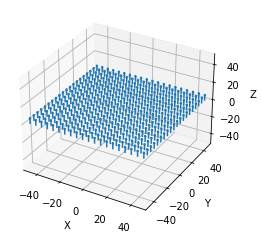

In [8]:
ax = plt.figure().add_subplot(projection='3d')
x, y, z = np.meshgrid(np.arange(-x_sample_size/nm/2+x_discretization_size/nm/2, x_sample_size/nm/2, x_discretization_size/nm),
                      np.arange(-y_sample_size/nm/2+y_discretization_size/nm/2, y_sample_size/nm/2, y_discretization_size/nm),
                      np.arange(-z_sample_size/nm/2+z_discretization_size/nm/2, z_sample_size/nm/2, z_discretization_size/nm))

u = M_array_cartesian[:,:,:,0]
v = M_array_cartesian[:,:,:,1]
w = M_array_cartesian[:,:,:,2]

ax.quiver(x, y, z, u, v, w, length=0.75*z_discretization_size/nm, normalize=False)
ax.set_xlim(-x_sample_size/nm/2, x_sample_size/nm/2)
ax.set_ylim(-y_sample_size/nm/2, y_sample_size/nm/2)
ax.set_zlim(-50, 50)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

## Calculate magnetic field from sample at an arbitract point in space

In [103]:
def B_at_coord_vec(coord_calc_arr: np.ndarray, # n_coord x 3
               M_array: np.ndarray, 
               sample_dims: Tuple[float, float, float], 
               sample_disc: Tuple[float, float, float], 
               sample_grid: Tuple[int, int, int]
              ) -> Tuple[float, float, float]:
    
    B_vec = np.zeros((3,len(coord_calc_arr)))
    n_coord = len(coord_calc_arr)
    
    center_coord_grid = np.mgrid[0:sample_grid[0], 0:sample_grid[1],0:sample_grid[2]]
    #center_coord_arr = np.zeros(center_coord_grid.shape)
    x_0_i_arr = (center_coord_grid[0,:,:,:].copy()*sample_discretization_size[0] -sample_dimensions[0]/2+sample_discretization_size[0]/2).flatten() 
    y_0_i_arr = (center_coord_grid[1,:,:,:].copy()*sample_discretization_size[1] -sample_dimensions[1]/2+sample_discretization_size[1]/2).flatten()
    z_0_i_arr = (center_coord_grid[2,:,:,:].copy()*sample_discretization_size[2] -sample_dimensions[2]/2+sample_discretization_size[2]/2).flatten()
    #center_coord_arr[0,:,:,:] = (center_coord_grid[0,:,:,:].copy()*sample_discretization_size[0] -sample_dimensions[0]/2+sample_discretization_size[0]/2).copy() 
    #center_coord_arr[1,:,:,:] = (center_coord_grid[1,:,:,:].copy()*sample_discretization_size[1] -sample_dimensions[1]/2+sample_discretization_size[1]/2).copy()
    #center_coord_arr[2,:,:,:] = (center_coord_grid[2,:,:,:].copy()*sample_discretization_size[2] -sample_dimensions[2]/2+sample_discretization_size[2]/2).copy()
    
    # extract magnitude and angles
    m_i_arr = M_array[:, :, :, 0].flatten()
    theta_i_arr = M_array[:, :, :, 1].flatten().reshape(-1,1)
    phi_i_arr = M_array[:, :, :, 2].flatten().reshape(-1,1)
    
    # create pairs array
    pairs_array = np.hstack((theta_i_arr, phi_i_arr))
    n_angles = len(pairs_array)
    coords_0_array = np.vstack((x_0_i_arr, y_0_i_arr, z_0_i_arr)).reshape((n_angles, 3))
    #print('with vstack: ', coords_0_array.shape)
    print(coords_0_array)
    print(pairs_array)
    
    B_components = B_i_vec(m_i_arr, coord_calc_arr, coords_0_array, pairs_array) # dimensions n_ang*n_coord x 3
    B_vec = np.sum(B_components.reshape((n_angles, n_coord, 3)), axis = 0)
    print('B_components shape ', B_components.shape)
    print('B_components ', B_components)
    print('B_components reshape shape ', B_components.reshape((n_angles, n_coord, 3)).shape)
    print('B_vec shape ', B_vec.shape)

    return B_vec

In [9]:
def B_at_coord_vec_3(coord_calc_arr: np.ndarray, # n_coord x 3
               M_array: np.ndarray, 
               sample_dims: Tuple[float, float, float], 
               sample_disc: Tuple[float, float, float], 
               sample_grid: Tuple[int, int, int]
              ) -> Tuple[float, float, float]:
    
    B_vec = np.zeros((3,len(coord_calc_arr)))
    n_coord = len(coord_calc_arr)
    
    center_coord_grid = np.mgrid[0:sample_grid[0], 0:sample_grid[1],0:sample_grid[2]]
    #center_coord_arr = np.zeros(center_coord_grid.shape)
    x_0_i_arr = (center_coord_grid[0,:,:,:].copy()*sample_discretization_size[0] -sample_dimensions[0]/2+sample_discretization_size[0]/2).flatten() 
    y_0_i_arr = (center_coord_grid[1,:,:,:].copy()*sample_discretization_size[1] -sample_dimensions[1]/2+sample_discretization_size[1]/2).flatten()
    z_0_i_arr = (center_coord_grid[2,:,:,:].copy()*sample_discretization_size[2] -sample_dimensions[2]/2+sample_discretization_size[2]/2).flatten()
    #center_coord_arr[0,:,:,:] = (center_coord_grid[0,:,:,:].copy()*sample_discretization_size[0] -sample_dimensions[0]/2+sample_discretization_size[0]/2).copy() 
    #center_coord_arr[1,:,:,:] = (center_coord_grid[1,:,:,:].copy()*sample_discretization_size[1] -sample_dimensions[1]/2+sample_discretization_size[1]/2).copy()
    #center_coord_arr[2,:,:,:] = (center_coord_grid[2,:,:,:].copy()*sample_discretization_size[2] -sample_dimensions[2]/2+sample_discretization_size[2]/2).copy()
    
    # extract magnitude and angles
    m_i_arr = M_array[:, :, :, 0].flatten()
    theta_i_arr = M_array[:, :, :, 1].flatten().reshape(-1,1)
    phi_i_arr = M_array[:, :, :, 2].flatten().reshape(-1,1)
    
    # create pairs array
    pairs_array = np.hstack((theta_i_arr, phi_i_arr))
    n_angles = len(pairs_array)
    #print('n_angles ', n_angles)
    coords_0_array = np.column_stack((x_0_i_arr, y_0_i_arr, z_0_i_arr)).reshape((n_angles, 3))
    
    B_components = B_i_vec_3(m_i_arr, coord_calc_arr, coords_0_array, pairs_array) # dimensions n_ang*n_coord x 3
    B_vec = np.sum(B_components.reshape((n_coord, n_angles, 3)), axis = 1)
    #print('B_components shape ', B_components.shape)
    #print('B_components ', B_components)
    #print('B_components reshape shape ', B_components.reshape((n_angles, n_coord, 3)).shape)
    #print('B_vec shape ', B_vec.shape)

    return B_vec

### Sanity checks

In [215]:

coord_calc_arr = np.array([[0, 0, dist_to_sample]])
print("Field components at (0,0,d)", B_at_coord_vec_3(coord_calc_arr, M_array, sample_dimensions, sample_discretization_size, sample_grid))

#coord_calc = (dist_to_sample, dist_to_sample, dist_to_sample)
#print("Field components at (d,d,d)", B_at_coord(coord_calc, M_array, sample_dimensions, sample_discretization_size, sample_grid))

#coord_calc = (-dist_to_sample, -dist_to_sample, dist_to_sample)
#print("Field components at (-d,-d,d)", B_at_coord(coord_calc, M_array, sample_dimensions, sample_discretization_size, sample_grid))

coord_calc_arr = np.array([[dist_to_sample, 0, 0]])
print("Field components at (d,0,0)", B_at_coord_vec_3(coord_calc_arr, M_array, sample_dimensions, sample_discretization_size, sample_grid))

coord_calc_arr = np.array([[0, 0, 10*dist_to_sample]])
print("Field components at (0,0,10d)", B_at_coord_vec_3(coord_calc_arr, M_array, sample_dimensions, sample_discretization_size, sample_grid))

Field components at (0,0,d) [[0.00000000e+00 0.00000000e+00 6.39904009e+12]]
Field components at (d,0,0) [[ 0.00000000e+00  0.00000000e+00 -3.20035999e+12]]
Field components at (0,0,10d) [[0.0000000e+00 0.0000000e+00 6.3999904e+09]]


## Define probe and fluctuations

In [38]:
probe_side = 50*nm
dist_to_sample = 500*nm

probe_area = probe_side**2

delta_a = 2*nm
del_x = 5*nm
del_y = 5*nm

## Calculating magnetic flux through SQUID loop at distance d above sample center

In [23]:
# vectorized
meshing_probe = (int(probe_side/delta_a), int(probe_side/delta_a)) # nx, ny
da_probe = probe_side/meshing_probe[0]
coord_calc = (0, 0, dist_to_sample)

xt, yt = np.meshgrid(np.arange(meshing_probe[0]), np.arange(meshing_probe[1]))

coord_calc_array = np.zeros((meshing_probe[0]*meshing_probe[1],3))
coord_calc_array[:,0] = coord_calc[0]-probe_side/2 + delta_a*(xt.flatten() + 0.5)
coord_calc_array[:,1] = coord_calc[1]-probe_side/2 + delta_a*(yt.flatten() + 0.5)
coord_calc_array[:,2] = coord_calc[2]

B_probe_units = B_at_coord_vec_3(coord_calc_array, M_array, sample_dimensions, sample_discretization_size, sample_grid)

B_probe_z = B_probe_units[:,2]
flux_arr = B_probe_z.reshape(meshing_probe)*(da_probe**2)


#for ix in range(meshing_probe[0]):
#    for iy in range(meshing_probe[1]):
#        print(ix, iy)
#        coord_calc_ix_iy = (coord_calc[0]-probe_side/2 + delta_a*(ix + 0.5), coord_calc[1]-probe_side/2 + delta_a*(iy + 0.5), coord_calc[2])
#        B_probe_segment = B_at_coord(coord_calc_ix_iy, M_array, sample_dimensions, sample_discretization_size, sample_grid)
#        flux_arr[ix, iy] = B_probe_segment[2]*(da_probe**2)

### Plotting magnetic flux per unit cell of probe meshing

/var/folders/zx/flxs9k9j3q1fr05sp0xh1kj40000gn/T/ipykernel_30713/1814971251.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(np.linspace(0,1,meshing_probe[0]), np.linspace(0,1,meshing_probe[1]), flux_arr)


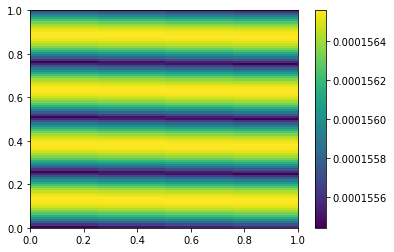

In [24]:
fig, ax = plt.subplots()
im = plt.pcolormesh(np.linspace(0,1,meshing_probe[0]), np.linspace(0,1,meshing_probe[1]), flux_arr)
fig.colorbar(im, ax=ax)

# why stripes? would have expected rotational invariance

In [25]:
# flux through loop roughly the same regarless of probe meshing
flux_through_loop = np.sum(flux_arr)
flux_through_loop

1.5617625377055315

## Sweeping the position of the SQUID loop and calculating the flux

In [39]:
x_min_probe_sweep = -100*nm
x_max_probe_sweep = 100*nm
y_min_probe_sweep = -100*nm
y_max_probe_sweep = 100*nm

nx_sweep = int((x_max_probe_sweep-x_min_probe_sweep)/del_x)
ny_sweep = int((y_max_probe_sweep-y_min_probe_sweep)/del_y)

x_probe_sweep = np.linspace(x_min_probe_sweep, x_max_probe_sweep, num=nx_sweep)
y_probe_sweep = np.linspace(y_min_probe_sweep, y_max_probe_sweep, num=ny_sweep)

flux_results = np.zeros((nx_sweep, ny_sweep))

for ix, x_p in enumerate(x_probe_sweep):
    for iy, y_p in enumerate(y_probe_sweep):
        if ix%10 == 0 or iy%10 == 0:
            print(ix, iy)
        meshing_probe = (int(probe_side/delta_a), int(probe_side/delta_a)) # nx, ny
        da_probe = probe_side/meshing_probe[0]
        coord_calc = (x_p, y_p, dist_to_sample)

        xt, yt = np.meshgrid(np.arange(meshing_probe[0]), np.arange(meshing_probe[1]))

        coord_calc_array = np.zeros((meshing_probe[0]*meshing_probe[1],3))
        coord_calc_array[:,0] = coord_calc[0]-probe_side/2 + delta_a*(xt.flatten() + 0.5)
        coord_calc_array[:,1] = coord_calc[1]-probe_side/2 + delta_a*(yt.flatten() + 0.5)
        coord_calc_array[:,2] = coord_calc[2]

        B_probe_units = B_at_coord_vec_3(coord_calc_array, M_array, sample_dimensions, sample_discretization_size, sample_grid)

        B_probe_z = B_probe_units[:,2]
        flux_arr = B_probe_z.reshape(meshing_probe)*(da_probe**2)
        flux_results[ix, iy] = np.sum(flux_arr)
        
                            
                            

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
1 0
1 10
1 20
1 30
2 0
2 10
2 20
2 30
3 0
3 10
3 20
3 30
4 0
4 10
4 20
4 30
5 0
5 10
5 20
5 30
6 0
6 10
6 20
6 30
7 0
7 10
7 20
7 30
8 0
8 10
8 20
8 30
9 0
9 10
9 20
9 30
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
10 17
10 18
10 19
10 20
10 21
10 22
10 23
10 24
10 25
10 26
10 27
10 28
10 29
10 30
10 31
10 32
10 33
10 34
10 35
10 36
10 37
10 38
10 39
11 0
11 10
11 20
11 30
12 0
12 10
12 20
12 30
13 0
13 10
13 20
13 30
14 0
14 10
14 20
14 30
15 0
15 10
15 20
15 30
16 0
16 10
16 20
16 30
17 0
17 10
17 20
17 30
18 0
18 10
18 20
18 30
19 0
19 10
19 20
19 30
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
20 11
20 12
20 13
20 14
20 15
20 16
20 17
20 18
20 19
20 20
20 21
20 22
20 23
20 24
20 25
20 26
20 27
20 28
20 29
20 30
20 31
20 32
20 33
20 34
20

/var/folders/zx/flxs9k9j3q1fr05sp0xh1kj40000gn/T/ipykernel_30713/1547306755.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(np.linspace(-100,100,nx_sweep), np.linspace(-100,100,ny_sweep), flux_results)


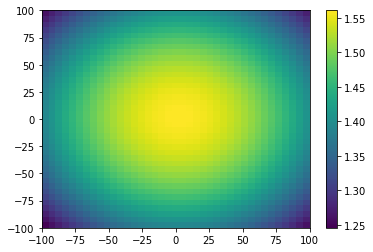

In [40]:
fig, ax = plt.subplots()
im = plt.pcolormesh(np.linspace(-100,100,nx_sweep), np.linspace(-100,100,ny_sweep), flux_results)
fig.colorbar(im, ax=ax)

In [41]:
np.savetxt('flux_arr_1.txt', flux_results)

## Generating rotated samples

In [ ]:
# Ideal ferromagnet

# Define size and meshing
x_sample_size = 100*nm
y_sample_size = 100*nm
z_sample_size = 10*nm

x_discretization_size = 5*nm
y_discretization_size = 5*nm
z_discretization_size = 10*nm

nx = int(x_sample_size/x_discretization_size)
ny = int(y_sample_size/y_discretization_size)
nz = int(z_sample_size/z_discretization_size)
print('Original dimensions (x, y ,z) in nm: ', x_sample_size/nm, y_sample_size/nm, z_sample_size/nm)
print('Dimensions after discretization (x, y ,z) in nm: ', nx*x_discretization_size/nm, ny*y_discretization_size/nm, nz*z_discretization_size/nm)

sample_dimensions = (x_sample_size, y_sample_size, z_sample_size)
sample_discretization_size = (x_discretization_size, y_discretization_size, z_discretization_size)
sample_grid = (nx, ny, nz)

# Stores magnetization as three values for each position coordinate: m_i, theta_i, phi_i
M_array = np.zeros((nx, ny, nz, 3))
M_array[:,:,:,0] = np.ones((nx, ny, nz))
M_array[:,:,:,1] = np.zeros((nx, ny, nz))
M_array[:,:,:,2] = np.zeros((nx, ny, nz))

# Stores magnetization as three values for each position coordinate: m_i_x, m_i_y, m_i_z
M_array_cartesian = np.ones_like(M_array) 
M_array_cartesian[:,:,:,2] = np.multiply(M_array[:,:,:,0], np.cos(M_array[:,:,:,1]))
M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(M_array[:,:,:,0], np.sin(M_array[:,:,:,1])), np.cos(M_array[:,:,:,2]))
M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(M_array[:,:,:,0], np.sin(M_array[:,:,:,1])), np.sin(M_array[:,:,:,2]))


In [104]:
def generate_rotated_ferromagnets(sample_sizes: Tuple[float, float, float], 
                                 discretization_sizes: Tuple[float, float, float],
                                 number_of_samples: int,
                                 m_i_uniform_magnitude: float) -> Tuple[np.ndarray, np.ndarray]:
    
    x_sample_size, y_sample_size, z_sample_size = sample_sizes
    x_discretization_size, y_discretization_size, z_discretization_size = discretization_sizes
    
    nx = int(x_sample_size/x_discretization_size)
    ny = int(y_sample_size/y_discretization_size)
    nz = int(z_sample_size/z_discretization_size)
    
    n_dipoles = nx*ny*nz
    
    center_coord_grid = np.mgrid[0:nx, 0:ny, 0:nz]
    x_0_i_arr = (center_coord_grid[0,:,:,:].copy()*x_discretization_size -x_sample_size/2+x_discretization_size/2).flatten() 
    y_0_i_arr = (center_coord_grid[1,:,:,:].copy()*y_discretization_size -y_sample_size/2+y_discretization_size/2).flatten()
    z_0_i_arr = (center_coord_grid[2,:,:,:].copy()*z_discretization_size -z_sample_size/2+z_discretization_size/2).flatten()
    coords_0_array = np.column_stack((x_0_i_arr, y_0_i_arr, z_0_i_arr)) #.reshape((nx,ny,nz, 3))
    
    M_array = np.zeros((nx, ny, nz, 3))
    M_array[:,:,:,0] = np.ones((nx, ny, nz))*m_i_uniform_magnitude
    M_array[:,:,:,1] = np.ones((nx, ny, nz))
    M_array[:,:,:,2] = np.ones((nx, ny, nz))
    
    M_array_cartesian = np.ones_like(M_array) 
    M_array_cartesian[:,:,:,2] = np.multiply(M_array[:,:,:,0], np.cos(M_array[:,:,:,1]))
    M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(M_array[:,:,:,0], np.sin(M_array[:,:,:,1])), np.cos(M_array[:,:,:,2]))
    M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(M_array[:,:,:,0], np.sin(M_array[:,:,:,1])), np.sin(M_array[:,:,:,2]))
    
    M_array_rotated = np.zeros((number_of_samples, nx, ny, nz, 3))
    center_coords_rotated = np.zeros((number_of_samples, nx, ny, nz, 3))
    
    for i in range(number_of_samples):
        theta_i_N = np.random.rand()*np.pi*2
        phi_i_N = np.random.rand()*np.pi*2
        
        M_array_rotated[i,:,:,:,0] = np.ones((nx, ny, nz))*m_i_uniform_magnitude
        M_array_rotated[i,:,:,:,1] = np.ones((nx, ny, nz))*theta_i_N
        M_array_rotated[i,:,:,:,2] = np.ones((nx, ny, nz))*phi_i_N
        
        angle_single_pair = np.array([theta_i_N, phi_i_N])
        angles_tuple = np.array(list(map(np.copy, [angle_single_pair] * n_dipoles)))
        angles_extended = angles_tuple.reshape((n_dipoles, 2))
        
        rot_matrices = rot_vec(angles_extended)
        rotated_coords_0 = np.einsum('ijk,ikl -> ijl', rot_matrices, coords_0_array.reshape((n_dipoles, 3, 1)))
        
        center_coords_rotated[i,:,:,:,:] = rotated_coords_0.reshape((nx,ny,nz, 3))
        
    return M_array_rotated, center_coords_rotated
        
        
        
        

### Santiy Check 1

In [84]:
x_sample_size = 100*nm
y_sample_size = 100*nm
z_sample_size = 10*nm

x_discretization_size = 5*nm
y_discretization_size = 5*nm
z_discretization_size = 10*nm

nx = int(x_sample_size/x_discretization_size)
ny = int(y_sample_size/y_discretization_size)
nz = int(z_sample_size/z_discretization_size)
    
n_dipoles = nx*ny*nz
    
center_coord_grid = np.mgrid[0:nx, 0:ny, 0:nz]
x_0_i_arr = (center_coord_grid[0,:,:,:].copy()*x_discretization_size -x_sample_size/2+x_discretization_size/2).flatten() 
y_0_i_arr = (center_coord_grid[1,:,:,:].copy()*y_discretization_size -y_sample_size/2+y_discretization_size/2).flatten()
z_0_i_arr = (center_coord_grid[2,:,:,:].copy()*z_discretization_size -z_sample_size/2+z_discretization_size/2).flatten()
coords_0_array = np.column_stack((x_0_i_arr, y_0_i_arr, z_0_i_arr)).reshape((nx,ny,nz, 3)) #.reshape((n_dipoles, 3))

In [97]:
print('If we rotate the plane by theta=np.pi/2 phi=np.pi/2, we expect the corners to move from the xy plane to the xz plane with the (-,-,0) corner at (+,0, +)')

test_rot = np.linalg.inv(rot_vec(np.array([[-np.pi/2, -np.pi/2]])))
test_vec = coords_0_array[0,0,0,:]
print('We obtain: ', np.matmul(test_rot, test_vec))

print('If we rotate the plane by theta=np.pi/2 phi=np.pi/2, we expect the corners to move from the xy plane to the xz plane with the (+,-,0) corner at (+,0,-)')

test_rot = np.linalg.inv(rot_vec(np.array([[-np.pi/2, -np.pi/2]])))
test_vec = coords_0_array[-1,0,0,:]
print('We obtain: ', np.matmul(test_rot, test_vec))

If we rotate the plane by theta=np.pi/2 phi=np.pi/2, we expect the corners to move from the xy plane to the xz plane with the (-,-,0) corner at (+,0, +)
We obtain:  [[ 4.7500000e-08 -5.8170723e-24  4.7500000e-08]]
If we rotate the plane by theta=np.pi/2 phi=np.pi/2, we expect the corners to move from the xy plane to the xz plane with the (+,-,0) corner at (+,0,-)
We obtain:  [[ 4.75e-08  0.00e+00 -4.75e-08]]


### Sanity Check 2

In [109]:
sample_sizes = (1*nm, 1*nm, 1*nm)
discretization_sizes = (1*nm, 1*nm, 1*nm)
number_of_samples = 1
m_i_uniform_magnitude = 1.0

M_arr_rot, coord_arr_rot = generate_rotated_ferromagnets(sample_sizes, 
                                 discretization_sizes,
                                 number_of_samples,
                                 m_i_uniform_magnitude)

print('Should have a rotated M_array but zero vector for coords_0.')
print('We obtain:')
print('M_array =', M_arr_rot)
print('coords_0 =', coord_arr_rot)

Should have a rotated M_array but zero vector for coords_0.
We obtain:
M_array = [[[[[1.         2.20335203 0.31242871]]]]]
coords_0 = [[[[[0. 0. 0.]]]]]


In [113]:
sample_sizes = (2*nm, 2*nm, 1*nm)
discretization_sizes = (1*nm, 1*nm, 1*nm)
number_of_samples = 1
m_i_uniform_magnitude = 1.0

M_arr_rot, coord_arr_rot = generate_rotated_ferromagnets(sample_sizes, 
                                 discretization_sizes,
                                 number_of_samples,
                                 m_i_uniform_magnitude)

print('Should have a rotated M_array and the corner vectors will contain symmetries.')
print('We obtain:')
print('M_array =', M_arr_rot)
print('coords_0 =', coord_arr_rot/nm)

Should have a rotated M_array and the corner vectors will contain symmetries.
We obtain:
M_array = [[[[[1.         2.21342979 4.66628613]]

   [[1.         2.21342979 4.66628613]]]


  [[[1.         2.21342979 4.66628613]]

   [[1.         2.21342979 4.66628613]]]]]
coords_0 = [[[[[ 0.28552448  0.52251199  0.38138825]]

   [[-0.31314439  0.47642547 -0.41828145]]]


  [[[ 0.31314439 -0.47642547  0.41828145]]

   [[-0.28552448 -0.52251199 -0.38138825]]]]]


### Sanity Check 3

Text(0.5, 0, 'Z')

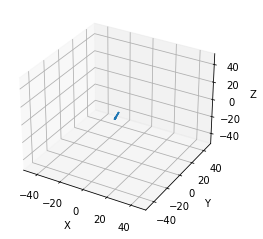

In [140]:
# START HERE!!! Visualizing rotated sample
ax = plt.figure().add_subplot(projection='3d')

x = coord_arr_rot[:,:,:,0,0]
y = coord_arr_rot[:,:,:,0,1]
z = coord_arr_rot[:,:,:,0,2]

M_array_cartesian = np.ones_like(M_arr_rot[:,:,:,0,:]) 
M_array_cartesian[:,:,:,2] = np.multiply(M_arr_rot[:,:,:,0,0], np.cos(M_arr_rot[:,:,:,0,1]))
M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(M_arr_rot[:,:,:,0,0], np.sin(M_arr_rot[:,:,:,0,1])), np.cos(M_arr_rot[:,:,:,0,2]))
M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(M_arr_rot[:,:,:,0,0], np.sin(M_arr_rot[:,:,:,0,1])), np.sin(M_arr_rot[:,:,:,0,2]))

u = M_array_cartesian[:,:,:,0]
v = M_array_cartesian[:,:,:,1]
w = M_array_cartesian[:,:,:,2]

ax.quiver(x, y, z, u, v, w, length=0.75*z_discretization_size/nm, normalize=False)
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_zlim(-50, 50)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [142]:
M_array_cartesian.shape

(1, 2, 2, 3)

In [135]:
y

array([[[ 5.22511985e-10,  4.76425467e-10],
        [-4.76425467e-10, -5.22511985e-10]]])

In [136]:
z

array([[[ 3.81388252e-10, -4.18281445e-10],
        [ 4.18281445e-10, -3.81388252e-10]]])

In [137]:
x_1, y_1, z_1 = np.meshgrid(x, y, z)